In [2]:
import xarray as xr


from matplotlib import pyplot as plt
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch_harmonics import RealSHT, InverseRealSHT
import cartopy.crs as ccrs

In [35]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create equiangular grid parameters
nlat = 8
nlon = 12

# Initialize spherical harmonic transform
lmax = nlat + 1 # Maximum degree for the transform


sht = RealSHT(nlat, nlon, lmax=lmax).to(device)
isht = InverseRealSHT(nlat, nlon, lmax=lmax).to(device)

def generate_known_spectrum_field():
    """
    Generate a field with a known power spectrum.
    We'll create a field with power only in l=0 and l=2 modes.
    """
    # Create empty spectral coefficients
    coeffs = torch.zeros((lmax, nlon // 2 + 1), dtype=torch.float32, device=device)
    coeffs_im = torch.zeros((lmax, nlon // 2 + 1), dtype=torch.float32, device=device)

    
    # Set specific coefficients
    # l=0, m=0 (constant term)
    coeffs[0, 0] = 1.0
    
    # l=2, m=0 (zonal harmonic - varies with latitude)
    coeffs[2, 0] = 2.0
    coeffs[2, -5] = 1.0
    # coeffs[2,2] = 3.0
    # coeffs[2,1] = 4.0

    
    coeffs = torch.view_as_complex(torch.stack([coeffs, coeffs_im], dim=-1))
    # Convert to physical space
    field = isht(coeffs)
    
    # Analytical power spectrum values
    true_power_spectrum = torch.zeros(lmax+1, dtype=torch.float32, device=device)
    true_power_spectrum[0] = 1.0**2  # Power for l=0 mode
    true_power_spectrum[2] = 2.0**2  # Power for l=2 mode
    
    return field, coeffs, true_power_spectrum

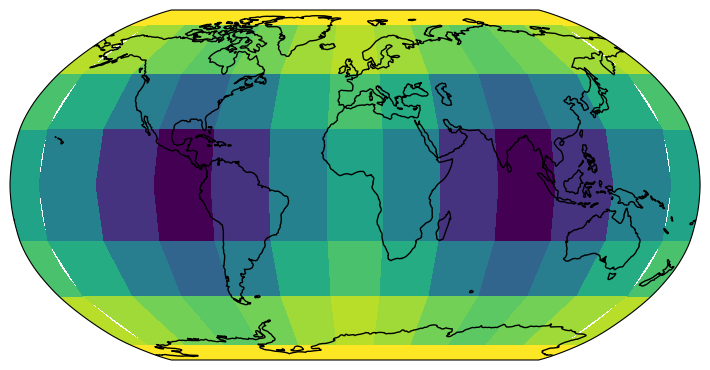

In [36]:
# Generate our test field
field, known_coeffs, true_spectrum = generate_known_spectrum_field()

# Transform back to spectral domain to verify
recovered_coeffs = sht(field)

# Compute power spectrum
# computed_spectrum = compute_power_spectrum(recovered_coeffs, lmax)

# Plot the results
plt.figure(figsize=(12, 10))

# Plot the spatial field
ax1 = plt.subplot(2, 1, 1, projection=ccrs.Robinson())
lons = np.linspace(0, 360, nlon, endpoint=False)
lats = np.linspace(-90, 90, nlat)
lon_grid, lat_grid = np.meshgrid(lons, lats)

ax1.coastlines()
im = ax1.pcolormesh(
    lon_grid, lat_grid, field.cpu().numpy(),
    transform=ccrs.PlateCarree(),
    cmap='viridis'
)

In [17]:
rand_field = torch.rand((nlat, nlon))

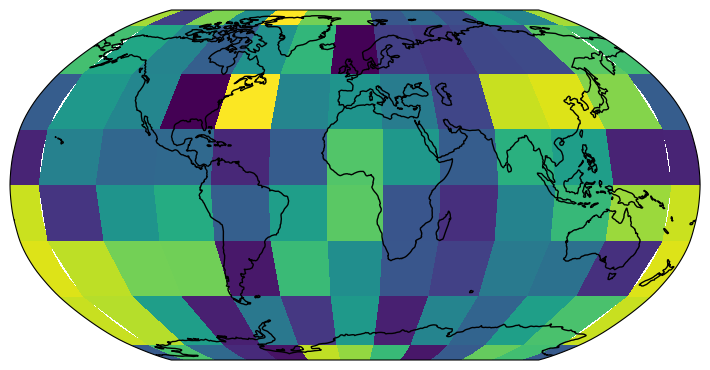

In [18]:
# Plot the results
plt.figure(figsize=(12, 10))

# Plot the spatial field
ax1 = plt.subplot(2, 1, 1, projection=ccrs.Robinson())
lons = np.linspace(0, 360, nlon, endpoint=False)
lats = np.linspace(-90, 90, nlat)
lon_grid, lat_grid = np.meshgrid(lons, lats)

ax1.coastlines()
im = ax1.pcolormesh(
    lon_grid, lat_grid, rand_field.cpu().numpy(),
    transform=ccrs.PlateCarree(),
    cmap='viridis'
)

In [19]:
coeffs = sht(rand_field)

In [21]:
coeffs.shape

torch.Size([9, 7])

In [22]:
coeffs

tensor([[ 1.6751e+00+0.0000e+00j,  0.0000e+00+0.0000e+00j,
          0.0000e+00+0.0000e+00j,  0.0000e+00+0.0000e+00j,
          0.0000e+00+0.0000e+00j,  0.0000e+00+0.0000e+00j,
          0.0000e+00+0.0000e+00j],
        [ 4.6173e-02+0.0000e+00j,  1.2007e-01+1.3177e-02j,
          0.0000e+00+0.0000e+00j,  0.0000e+00+0.0000e+00j,
          0.0000e+00+0.0000e+00j,  0.0000e+00+0.0000e+00j,
          0.0000e+00+0.0000e+00j],
        [ 1.7625e-02+0.0000e+00j,  1.1152e-01-1.1628e-01j,
          7.2547e-02+8.3842e-02j,  0.0000e+00+0.0000e+00j,
          0.0000e+00+0.0000e+00j,  0.0000e+00+0.0000e+00j,
          0.0000e+00+0.0000e+00j],
        [-4.2646e-02+0.0000e+00j,  1.7563e-01-7.6030e-02j,
          1.0168e-01-9.7384e-02j, -1.6957e-01-4.5253e-02j,
          0.0000e+00+0.0000e+00j,  0.0000e+00+0.0000e+00j,
          0.0000e+00+0.0000e+00j],
        [-8.9342e-02+0.0000e+00j, -6.1966e-02+1.2126e-01j,
          4.4956e-02+2.1626e-02j,  1.8023e-02+3.8093e-02j,
          1.3392e-01-1.7476e-02j, 